## Background

In this notebook I'll solidy the matrix multiplication concepts taught in Lesson 11 of the fastai course (part 2). Most importantly, I want to make sure I understand the use of broadcasting to make the matmul operation 7000x faster!

Here's a summary of run times for the five methods explored in this blog post:

|Method|Images|Run Time (ms)|
|:-:|:-:|:-:|
|Python for-loops|5|1090ms|
|Numba-compiled Dot Product|5|0.555ms|
|Python Dot Product|5|1.47ms|
|PyTorch Dot Product|5|1.22ms|
|PyTorch Broadcasting|5|0.158ms|
|Numba-compiled Broadcasting|5|0.0936ms|

Here's my video walkthrough of the code in this notebook:

<iframe width="560" height="315" src="https://www.youtube.com/embed/-t8b7Otfmjo?si=XxML2gDu0u2H9P0g" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Load the Data

We'll use the MNIST dataset for this exercise.

In [76]:
import torch
from torch import tensor
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt
from urllib.request import urlretrieve
import numpy as np

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [3]:
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Apr 21 22:56 mnist.pkl.gz


In [5]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [6]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

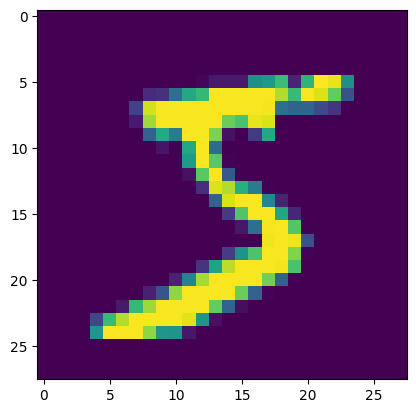

In [7]:
plt.imshow(imgs[0]);

For our weights, we'll create a set of random floats with shape 784 (rows) x 10 (columns). In an applied sense, these 10 outputs would be the logits associated with the ten possible digits (0-9) for each 28x28 image.

In [8]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
weights.shape

torch.Size([784, 10])

For our inputs (which get multiplied by our weights) we'll use the first 5 digits (28x28 images) from the validation set. These inputs and our weights are the two matrices we want to multiply!

In [9]:
m1 = x_valid[:5]
m2 = weights

In [10]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## Initial Solution: Python for-Loops

![Naive implementation of matrix multiplication](1.png)

For our first iteration, we'll do a nested for-loop---the most naive implementation of matrix multiplication in this exercise.

We iterate through the 5 rows of our input matrix (images). For each row, we iterate through each column of our weights matrix. For each of the 784 elements in that row/column (i,j) combination, we take the dot product and store it in the output matrix. 5 images x 10 outputs x 784 elements = 39200 total items operated on.

In [11]:
5*10*784

39200

In [12]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [13]:
t1 = torch.zeros(ar, bc) # resultant tensor
t1.shape

torch.Size([5, 10])

In [14]:
for i in range(ar): #5
    for j in range(bc): # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

The resulting matrix has 5 rows (1 for each image) and 10 columns (one for each "neuron" in our weights matrix).

In [15]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [24]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)

Wrapping this code into a function we can time it.

In [135]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [137]:
%time _=matmul(m1, m2)

CPU times: user 1.09 s, sys: 544 µs, total: 1.09 s
Wall time: 1.09 s


It takes a whopping 1.09 seconds to perform this matrix multiplication for 5 images! Let's optimize this with numba.

## Compiling the Dot Product with Numba

![Matrix multiplication using a numba-compiled dot product operation](2.png)

To reduce the number of python for-loops, we write the dot product (between the two 784-element vectors) in numba:

In [70]:
from numba import njit

In [139]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [71]:
from numpy import array

The first run of `dot` takes longer as it includes the compile time:

In [141]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 123 ms, sys: 0 ns, total: 123 ms
Wall time: 124 ms


20.0

The second run is 250x times faster.

In [143]:
0.124/0.000489

253.5787321063395

In [142]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 40 µs, sys: 5 µs, total: 45 µs
Wall time: 48.9 µs


20.0

We replace the third for-loop with our numba `dot` function:

In [160]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [68]:
m1a,m2a = m1.numpy(),m2.numpy()

In [56]:
from fastcore.test import *

We test that it yields the same result:

In [163]:
test_close(t1,matmul(m1a, m2a))

In [151]:
%timeit -n 50 matmul(m1a,m2a)

555 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Our numba-compiled `dot` operation makes our matrix multiplication 2000x faster!

In [152]:
1.09/555e-6

1963.963963963964

The same operation can be done in Python:

In [164]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [165]:
test_close(t1,matmul(m1, m2))

But it's three times slower than numba:

In [166]:
%timeit -n 50 _=matmul(m1, m2)

1.47 ms ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


Using `torch.dot` is a smidge faster than Python:

In [167]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [168]:
test_close(t1,matmul(m1, m2))

In [169]:
%timeit -n 50 _=matmul(m1, m2)

1.22 ms ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Faster: Use Broadcasting!

![Using broadcasting to compute all image/weight dot products simultaneously!](3.png)

Broadcasting effectively expands the smaller matrix to match the size of the larger one so that element-wise operations can take place.

Suppose we wanted to take the dot product between the first image and all 10 columns of weights. Adding a `None` during indexing adds a unit axis at that position:

In [21]:
m1[0,:].shape

torch.Size([784])

In [22]:
m1[0, :, None].shape

torch.Size([784, 1])

In [23]:
m2.shape

torch.Size([784, 10])

Multiplying (element-wise) `m1[0, :, None]` with `m2` _broadcasts_ `m1[0, :, None]` across the 10 columns of `m2`. In other words, each row of `m1[0]` is virtually copied over 10 times, one for each column of `m2`.  

In [25]:
(m1[0, :, None] * m2).shape

torch.Size([784, 10])

In [36]:
m1.shape

torch.Size([5, 784])

In [42]:
m1

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Here's a smaller example. `a` has 5 rows, "images", each with 4 pixels.

In [37]:
a = torch.randint(low=1, high=5, size=(5,4))
a

tensor([[1, 4, 3, 4],
        [1, 4, 1, 3],
        [3, 2, 2, 4],
        [3, 1, 3, 1],
        [2, 3, 1, 1]])

We pluck out the first "image" with `0`, then add a unit axis at the end with `None` to make it "broadcastable"

In [38]:
a[0, :, None]

tensor([[1],
        [4],
        [3],
        [4]])

In [43]:
a.shape, a[0, :, None].shape

(torch.Size([5, 4]), torch.Size([4, 1]))

Suppose we have weights `w` with 4 rows, each 10 columns wide.

In [47]:
w = torch.randint(low=1, high=5, size=(4, 10))
w

tensor([[2, 2, 1, 1, 4, 3, 4, 2, 4, 3],
        [1, 2, 4, 2, 4, 1, 3, 1, 2, 1],
        [4, 3, 4, 3, 1, 2, 1, 3, 3, 4],
        [1, 3, 3, 3, 3, 1, 1, 1, 4, 4]])

We broadcast the 4-vector `a[0, :, None]` across all 10 4-vectors in `w`:

In [48]:
a[0, :, None] * w

tensor([[ 2,  2,  1,  1,  4,  3,  4,  2,  4,  3],
        [ 4,  8, 16,  8, 16,  4, 12,  4,  8,  4],
        [12,  9, 12,  9,  3,  6,  3,  9,  9, 12],
        [ 4, 12, 12, 12, 12,  4,  4,  4, 16, 16]])

Then take the sum down the columns (along the row axis) to get the 10 output "activations" for this "image":

In [49]:
(a[0, :, None] * w).sum(dim=0)

tensor([22, 31, 41, 30, 35, 17, 23, 19, 37, 35])

Looking at the first value of `22`, it comes from the dot product between the first "image" in `a` and the first row of weights (the "neuron") in `w`:

22 = 1\*2 + 4\*1 + 3\*4 + 4\*1 = 2 + 4 + 12 + 4

In this way, we have the dot product between the first image and all 10 columns. This is the first row of the matrix product between `a` and `w`.

We can then loop over the images, broadcasting it across the weight matrix, summing down the columns to get each subsequent row of our resultant matrix product:

In [51]:
(ar,ac),(wr,wc) = a.shape,w.shape
ar,ac,wr,wc

(5, 4, 4, 10)

In [52]:
c = torch.zeros(ar, wc)
c.shape

torch.Size([5, 10])

In [53]:
for i in range(ar):
    c[i] = (a[i, :, None] * w).sum(dim=0)
c

tensor([[22., 31., 41., 30., 35., 17., 23., 19., 37., 35.],
        [13., 22., 30., 21., 30., 12., 20., 12., 27., 23.],
        [20., 28., 31., 25., 34., 19., 24., 18., 38., 35.],
        [20., 20., 22., 17., 22., 17., 19., 17., 27., 26.],
        [12., 16., 21., 14., 24., 12., 19., 11., 21., 17.]])

In this way, we have performed matrix multiplication by taking the dot product of each row/column using broadcasting! Returning to our original dataset:

In [64]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i]  = (a[i,:,None] * b).sum(dim=0)
    return c

In [65]:
test_close(t1,matmul(m1, m2))

In [58]:
%timeit -n 50 _=matmul(m1, m2)

158 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


This gives us a 8x speedup from the numba-compiled dot product (1.22ms --> 0.158 ms).

Now, instead of 5 images we can perform matmul with all 50k images in our dataset.

In [59]:
tr = matmul(x_train, weights)
tr

tensor([[  0.96,  -2.96,  -2.11,  ..., -15.09, -17.69,   0.60],
        [  6.89,  -0.34,   0.79,  ..., -17.13, -25.36,  16.23],
        [-10.18,   7.38,   4.13,  ...,  -6.73,  -6.79,  -1.58],
        ...,
        [  7.40,   7.64,  -3.50,  ...,  -1.02, -16.22,   2.07],
        [  3.25,   9.52,  -9.37,  ...,   2.98, -19.58,  -1.96],
        [ 15.70,   4.12,  -5.62,  ...,   8.08, -12.21,   0.42]])

In [60]:
tr.shape

torch.Size([50000, 10])

This operation now takes less than two seconds!

In [63]:
%time _=matmul(x_train, weights)

CPU times: user 1.62 s, sys: 0 ns, total: 1.62 s
Wall time: 1.63 s


## Fastest: Numba Broadcasting

In [69]:
m1a.shape, m2a.shape

((5, 784), (784, 10))

In [81]:
@njit
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = np.zeros((ar, bc))
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(axis=0)
    return c

In [82]:
test_close(t1,matmul(m1a, m2a))

In [86]:
%timeit -n 50 _=matmul(m1a, m2a)

93.6 µs ± 9.26 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


We can now perform matrix multiplication for all 50_000 images in less time than we could for 5 images using nested for-loops. AMAZING!

In [91]:
%time _=matmul(x_train.numpy(), weights.numpy())

CPU times: user 885 ms, sys: 0 ns, total: 885 ms
Wall time: 881 ms


## Final Thoughts

I've been busy with other ML projects over the past few months but I'm so glad I have gotten back in the driver's seat for fastai course part 2! The videos, content, and potential projects/exercises that spring forth are absolutely delicious. Using relatively simple building blocks, I was able to understand matrix multiplication through Python loops, numba dot product, and Yorick-inspired PyTorch broadcasting. Creating the visuals (in excalidraw) was a _must_ because I really needed to cement these concepts in my mind, as encouraged by Jeremy in the video.


Here's the summary again of run times for each of the methods shown above:

|Method|Images|Run Time (ms)|
|:-:|:-:|:-:|
|Python for-loops|5|1090ms|
|Numba-compiled Dot Product|5|0.555ms|
|Python Dot Product|5|1.47ms|
|PyTorch Dot Product|5|1.22ms|
|PyTorch Broadcasting|5|0.158ms|
|Numba-compiled Broadcasting|5|0.0936ms|

Using numba-compiled broadcasting, the 5-image matrix multiplication with weights experienced a 12000x speedup compared to the naive Python nested for-loop implementation! Amazing!!